In [1]:
!pip install ultralytics==8.3.124 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inco

# Imports

In [2]:
import os
import glob
import yaml 
import random
import shutil
import torch 

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Constants

In [3]:
# --- Configuration ---
BASE_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset'
ORIGINAL_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Original_Data')
AUGMENTED_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Augmented_Data')

# Define paths for augmented data splits
TRAIN_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'labels')
VALID_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'images')
VALID_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'images')
TEST_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'labels')

# Class names corresponding to IDs 0-5
class_names = ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']
num_classes = len(class_names)

# Using relative paths makes the yaml file more portable
INPUT_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data'
TRAIN_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'train', 'images')
VALID_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'valid', 'images')
TEST_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'test', 'images')

# Output directory for the yaml file (in the working directory)
YAML_DIR = '/kaggle/working/'
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')

# Step1: Verify Folder Structure

In [4]:
def check_and_count_files(dir_path, extensions=['.jpg', '.txt', '.json']):
    """Checks if a directory exists and counts files with given extensions."""
    if not os.path.isdir(dir_path):
        print(f"Directory NOT FOUND: {dir_path}")
        return None
    
    counts = {ext: 0 for ext in extensions}
    all_files = glob.glob(os.path.join(dir_path, '*'))
    
    for f in all_files:
        for ext in extensions:
            if f.lower().endswith(ext):
                counts[ext] += 1
                break # Count each file only once based on the first matching extension
                
    count_str = ", ".join([f"{count} {ext}" for ext, count in counts.items() if count > 0])
    print(f"Found: {dir_path} - Contains: {count_str if count_str else '0 files specified'}")
    return counts

# Check Original Data
print("\n[Original Data]")
# Note: Original data description mentions .json labels, but the folder structure implies .txt. Let's check both.
# Correction based on user prompt: Original_Data also has .txt labels.
original_img_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))
original_lbl_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.txt'))
print(f"Found: {ORIGINAL_DATA_DIR}")
print(f"  - Images (.jpg): {len(original_img_files)}")
print(f"  - Labels (.txt): {len(original_lbl_files)}")
# If JSON exists, check them too:
original_json_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.json'))
if original_json_files:
    print(f"  - Labels (.json): {len(original_json_files)}")


# Check Augmented Data
print("\n[Augmented Data]")
train_img_count = len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
train_lbl_count = len(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))
valid_img_count = len(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
valid_lbl_count = len(glob.glob(os.path.join(VALID_LBL_DIR, '*.txt')))
test_img_count = len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))
test_lbl_count = len(glob.glob(os.path.join(TEST_LBL_DIR, '*.txt')))

print(f"Train: Images={train_img_count}, Labels={train_lbl_count}")
print(f"Valid: Images={valid_img_count}, Labels={valid_lbl_count}")
print(f"Test:  Images={test_img_count}, Labels={test_lbl_count}")

# Basic consistency check
if train_img_count != train_lbl_count or valid_img_count != valid_lbl_count or test_img_count != test_lbl_count:
    print("\n*** WARNING: Mismatch between image and label counts in augmented data splits! ***")
else:
    print("\nImage and label counts match in augmented data splits.")


[Original Data]
Found: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Original_Data
  - Images (.jpg): 232
  - Labels (.txt): 232

[Augmented Data]
Train: Images=567, Labels=558
Valid: Images=23, Labels=23
Test:  Images=23, Labels=23

*** WARNING: Mismatch between image and label counts in augmented data splits! ***


## Step 2: Examine Label Format (YOLO Detection)

In [5]:
def examine_label_file_detection(label_path):
    """Reads a YOLO detection label file and prints its format info."""
    print(f"\nExamining: {label_path}")
    if not os.path.exists(label_path):
        print("File not found.")
        return None

    lines_info = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print("Label file is empty.")
            return []

        print(f"Number of bounding boxes (lines): {len(lines)}")

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 5: # Expecting class_id cx cy w h
                 print(f"  - Line {i+1}: Invalid format - expected 5 parts, found {len(parts)}. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'parts': len(parts), 'content': line.strip()})
                 continue

            try:
                class_id = int(parts[0])
                cx = float(parts[1])
                cy = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                coords = np.array([cx, cy, w, h])

                if not np.all((coords >= 0.0) & (coords <= 1.0)):
                    print(f"  - Line {i+1}: Invalid format - coordinates or dimensions out of [0, 1] range. Class: {class_id}, Values: {coords}")
                    lines_info.append({'valid': False, 'class': class_id, 'coords': coords.tolist(), 'content': line.strip()})
                else:
                    info = {'valid': True, 'class': class_id, 'cx': cx, 'cy': cy, 'w': w, 'h': h}
                    lines_info.append(info)
                    if i < 5: # Print details only for the first few lines
                         print(f"  - Line {i+1}: Class={class_id}, CenterX={cx:.4f}, CenterY={cy:.4f}, Width={w:.4f}, Height={h:.4f}")

            except ValueError:
                 print(f"  - Line {i+1}: Invalid format - non-numeric values found. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'content': line.strip()})

    except Exception as e:
        print(f"Error reading or parsing {label_path}: {e}")
        return None

    return lines_info

# Examine one label file from the training set
sample_label_files = glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))
if sample_label_files:
    examine_label_file_detection(random.choice(sample_label_files))
else:
    print("No label files found in training set to examine.")


Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/72_jpg.rf.8e973a7cb24044f9290763df3485cbe9.txt
Number of bounding boxes (lines): 4
  - Line 1: Class=0, CenterX=0.3375, CenterY=0.5867, Width=0.0922, Height=0.2500
  - Line 2: Class=0, CenterX=0.6984, CenterY=0.4200, Width=0.0594, Height=0.2000
  - Line 3: Class=5, CenterX=0.3344, CenterY=0.3700, Width=0.0578, Height=0.2467
  - Line 4: Class=5, CenterX=0.7453, CenterY=0.4133, Width=0.0625, Height=0.2533


## Step 3: Visualize Sample Images and Bounding Boxes


--- Visualizing Training Samples ---

Visualizing: 64_jpg.rf.885d05ec1b56d1bad616efc56ac8d72a.jpg
Image dimensions (HxW): 413 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/64_jpg.rf.885d05ec1b56d1bad616efc56ac8d72a.txt
Number of bounding boxes (lines): 11
  - Line 1: Class=5, CenterX=0.4719, CenterY=0.3547, Width=0.0656, Height=0.0896
  - Line 2: Class=0, CenterX=0.3539, CenterY=0.3184, Width=0.0891, Height=0.1622
  - Line 3: Class=0, CenterX=0.5852, CenterY=0.3656, Width=0.0672, Height=0.0678
  - Line 4: Class=5, CenterX=0.7578, CenterY=0.0847, Width=0.0875, Height=0.1695
  - Line 5: Class=2, CenterX=0.7981, CenterY=0.2563, Width=0.1006, Height=0.1462
Drawn 11 bounding boxes.


/tmp/ipykernel_31/936133588.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)


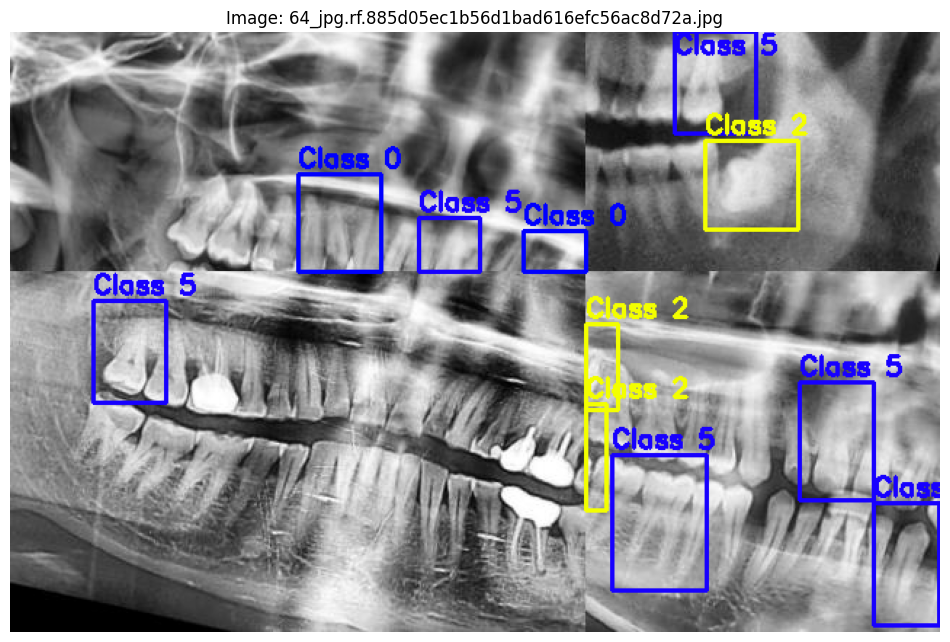


Visualizing: 238_jpg.rf.cbffef32ef786b116f9f6861474eb745.jpg
Image dimensions (HxW): 306 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/238_jpg.rf.cbffef32ef786b116f9f6861474eb745.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=5, CenterX=0.3133, CenterY=0.1748, Width=0.0828, Height=0.2843
  - Line 2: Class=5, CenterX=0.1469, CenterY=0.2304, Width=0.0688, Height=0.1732
  - Line 3: Class=5, CenterX=0.5352, CenterY=0.2533, Width=0.0703, Height=0.1275
  - Line 4: Class=2, CenterX=0.2935, CenterY=0.7157, Width=0.0964, Height=0.1998
  - Line 5: Class=5, CenterX=0.2212, CenterY=0.5152, Width=0.0639, Height=0.2497
Drawn 7 bounding boxes.


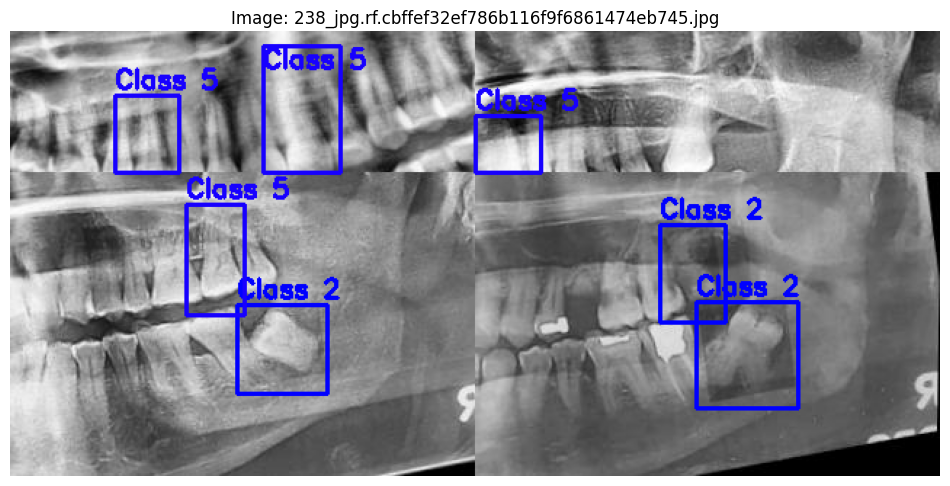


--- Visualizing Validation Samples ---

Visualizing: 42_jpg.rf.aea2d4e19ad98bded7f10429b293d510.jpg
Image dimensions (HxW): 340 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/42_jpg.rf.aea2d4e19ad98bded7f10429b293d510.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=0, CenterX=0.6766, CenterY=0.5324, Width=0.0594, Height=0.2324
  - Line 2: Class=2, CenterX=0.2375, CenterY=0.4853, Width=0.0781, Height=0.1294
  - Line 3: Class=2, CenterX=0.7766, CenterY=0.4941, Width=0.0828, Height=0.1647
  - Line 4: Class=0, CenterX=0.6656, CenterY=0.7647, Width=0.0766, Height=0.2353
  - Line 5: Class=0, CenterX=0.3219, CenterY=0.5412, Width=0.0656, Height=0.2029
Drawn 7 bounding boxes.


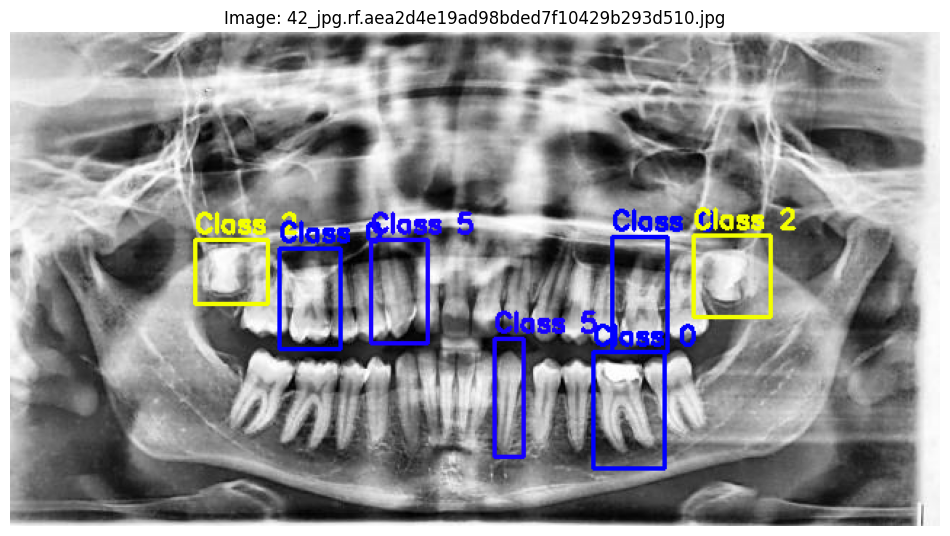


Visualizing: 41_jpg.rf.4d4ea51e147bf60d2e858e5baa5c2c23.jpg
Image dimensions (HxW): 372 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/41_jpg.rf.4d4ea51e147bf60d2e858e5baa5c2c23.txt
Number of bounding boxes (lines): 2
  - Line 1: Class=5, CenterX=0.3594, CenterY=0.5995, Width=0.0813, Height=0.2070
  - Line 2: Class=5, CenterX=0.7688, CenterY=0.5457, Width=0.0938, Height=0.1694
Drawn 2 bounding boxes.


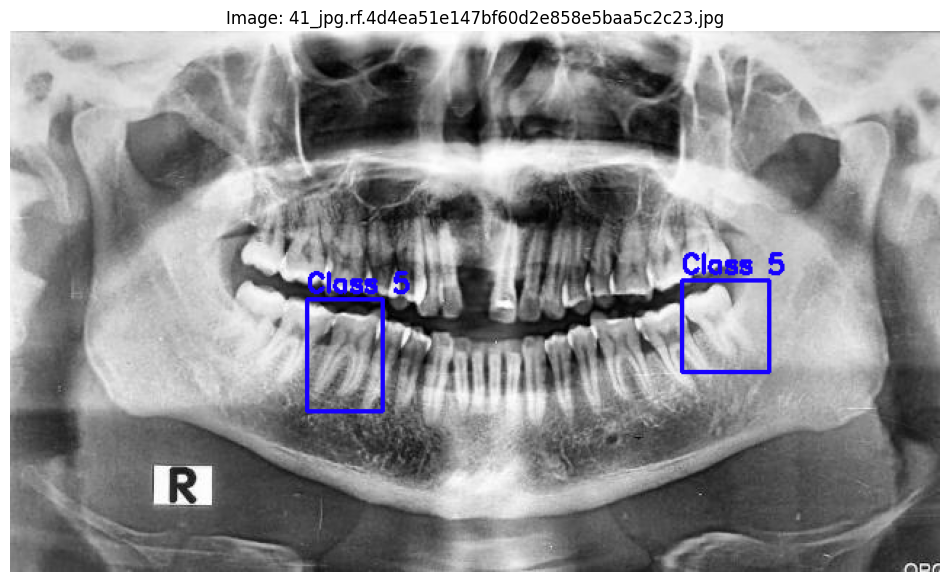


--- Visualizing Test Samples ---

Visualizing: 106_jpg.rf.55f75c16fffc0fea03b260bf91b8fc68.jpg
Image dimensions (HxW): 332 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/106_jpg.rf.55f75c16fffc0fea03b260bf91b8fc68.txt
Number of bounding boxes (lines): 4
  - Line 1: Class=4, CenterX=0.3906, CenterY=0.6958, Width=0.0437, Height=0.1416
  - Line 2: Class=4, CenterX=0.5875, CenterY=0.7199, Width=0.0391, Height=0.1416
  - Line 3: Class=5, CenterX=0.4484, CenterY=0.7169, Width=0.0437, Height=0.2108
  - Line 4: Class=5, CenterX=0.4344, CenterY=0.4759, Width=0.0359, Height=0.2560
Drawn 4 bounding boxes.


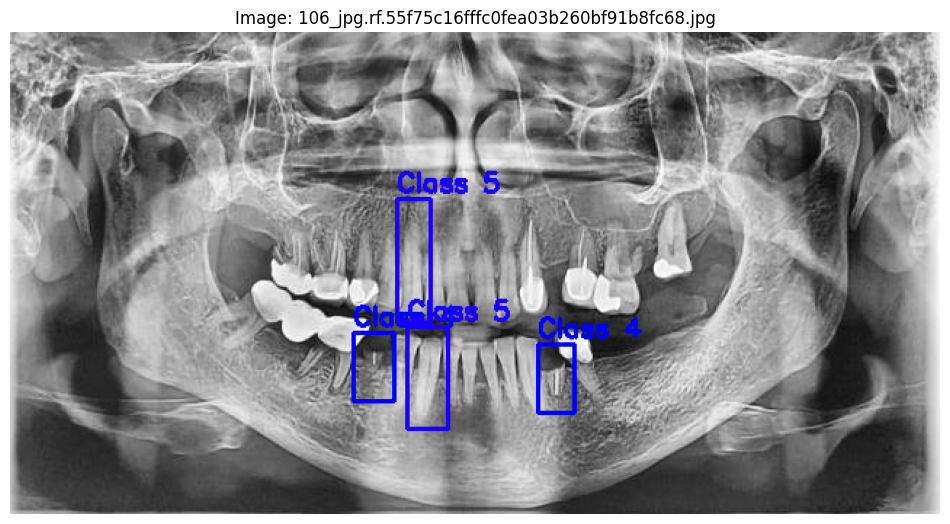


Visualizing: 77_jpg.rf.c4454db6f13c687c33b3527c2ed1c34d.jpg
Image dimensions (HxW): 281 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/77_jpg.rf.c4454db6f13c687c33b3527c2ed1c34d.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=5, CenterX=0.7812, CenterY=0.3808, Width=0.0719, Height=0.2740
  - Line 2: Class=1, CenterX=0.5844, CenterY=0.7082, Width=0.0594, Height=0.2847
  - Line 3: Class=5, CenterX=0.5094, CenterY=0.4164, Width=0.0484, Height=0.2954
  - Line 4: Class=1, CenterX=0.4344, CenterY=0.2740, Width=0.0953, Height=0.3025
  - Line 5: Class=1, CenterX=0.6062, CenterY=0.2705, Width=0.1297, Height=0.2313
Drawn 7 bounding boxes.


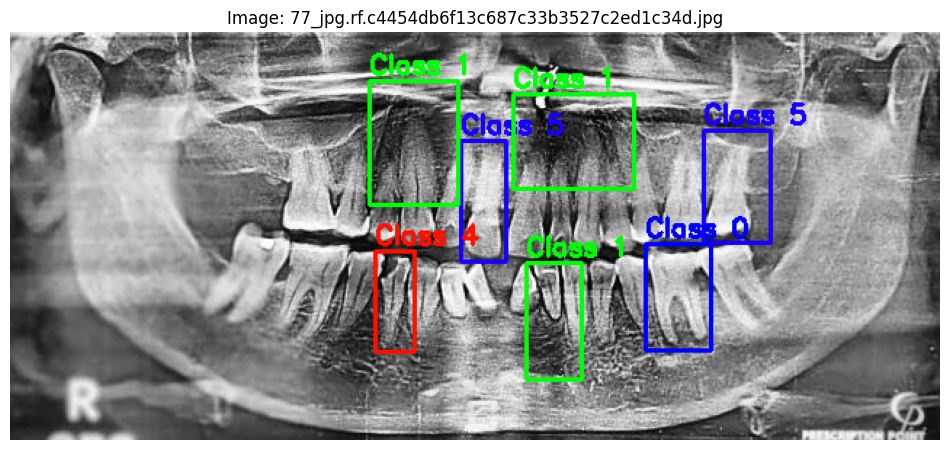

In [6]:
def display_image_with_boxes(image_path, label_path, num_samples=1):
    """Loads an image and its corresponding YOLO detection label, then displays them."""
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        # Optionally display the image without boxes if label is missing
        # img = cv2.imread(image_path)
        # if img is not None:
        #     plt.figure(figsize=(10, 7))
        #     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #     plt.title(f"Image: {os.path.basename(image_path)} (No Label Found)")
        #     plt.axis('off')
        #     plt.show()
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img_h, img_w = img.shape[:2]
    img_display = img.copy() # Work on a copy

    print(f"\nVisualizing: {os.path.basename(image_path)}")
    print(f"Image dimensions (HxW): {img_h} x {img_w}")

    lines_info = examine_label_file_detection(label_path) # Use updated examination function

    if lines_info is None or not lines_info:
        print("No valid bounding boxes found or error reading label file.")
    else:
        # Generate distinct colors for classes
        valid_classes = [info['class'] for info in lines_info if info['valid']]
        unique_classes = sorted(list(set(valid_classes))) if valid_classes else []
        # Use a colormap suitable for potentially many classes
        colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)
        class_colors = {cls: tuple(int(c*255) for c in colors(i)[:3]) for i, cls in enumerate(unique_classes)} # BGR for OpenCV

        box_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: continue # Skip invalid lines

                try:
                    class_id = int(parts[0])
                    cx = float(parts[1])
                    cy = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Denormalize coordinates and dimensions
                    center_x_abs = cx * img_w
                    center_y_abs = cy * img_h
                    box_w_abs = w * img_w
                    box_h_abs = h * img_h

                    # Calculate top-left (x1, y1) and bottom-right (x2, y2) coordinates
                    x1 = int(center_x_abs - box_w_abs / 2)
                    y1 = int(center_y_abs - box_h_abs / 2)
                    x2 = int(center_x_abs + box_w_abs / 2)
                    y2 = int(center_y_abs + box_h_abs / 2)

                    # Ensure coordinates are within image bounds (important for drawing)
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w - 1, x2)
                    y2 = min(img_h - 1, y2)

                    color = class_colors.get(class_id, (0, 0, 255)) # Default to red if class not found
                    label_text = f"Class {class_id}" # You might want to map this to actual names later

                    # Draw the bounding box rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness=2)
                    # Add class label text above the box
                    cv2.putText(img_display, label_text, (x1, y1 - 5 if y1 > 10 else y1 + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    box_count += 1

                except Exception as e:
                    print(f"Error processing line for drawing: {line.strip()} - {e}")
        print(f"Drawn {box_count} bounding boxes.")


    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for plt
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Get lists of files (Keep as before)
train_image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
valid_image_files = sorted(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
test_image_files = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))

# Visualize a few samples from each split (Use updated function name)
num_samples_to_show = 2

print("\n--- Visualizing Training Samples ---")
for i in range(min(num_samples_to_show, len(train_image_files))):
    idx = random.randint(0, len(train_image_files)-1) # Pick random samples
    img_file = train_image_files[idx]
    lbl_file = os.path.join(TRAIN_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Validation Samples ---")
for i in range(min(num_samples_to_show, len(valid_image_files))):
    idx = random.randint(0, len(valid_image_files)-1)
    img_file = valid_image_files[idx]
    lbl_file = os.path.join(VALID_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Test Samples ---")
for i in range(min(num_samples_to_show, len(test_image_files))):
    idx = random.randint(0, len(test_image_files)-1)
    img_file = test_image_files[idx]
    lbl_file = os.path.join(TEST_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function



## Step 4: Basic Statistics

In [7]:
image_widths = []
image_heights = []
boxes_per_image = [] # Changed name from segments_per_image
all_class_ids = set()
empty_label_files = 0

train_label_files = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))

for lbl_file in train_label_files:
    img_file = os.path.join(TRAIN_IMG_DIR, os.path.basename(lbl_file).replace('.txt', '.jpg'))

    if not os.path.exists(img_file):
        print(f"Warning: Corresponding image not found for label {lbl_file}")
        continue

    # Image dimensions (Keep as before)
    try:
        # Optimization: Use cv2.imread only once if needed for both stats and visualization later
        # Or use a library like PIL to get dimensions without loading the full image if memory is a concern
        img = cv2.imread(img_file)
        if img is not None:
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)
        else:
            print(f"Warning: Could not read image {img_file}")
            continue
    except Exception as e:
        print(f"Error reading image {img_file}: {e}")
        continue

    # Label info (Logic adapted for detection format)
    try:
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        num_boxes = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5: # Check for valid detection line format
                num_boxes += 1
                try:
                    all_class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Non-integer class ID found in {lbl_file}: {parts[0]}")
            elif parts: # If line is not empty but has wrong format
                 print(f"Warning: Invalid line format in {lbl_file}: '{line.strip()}'")


        boxes_per_image.append(num_boxes)

        if num_boxes == 0 and lines: # Label file exists but has no valid lines or is empty
             print(f"Warning: Label file {lbl_file} seems empty or contains only invalid lines.")
             if not lines:
                 empty_label_files += 1 # Count files that are truly empty


    except Exception as e:
        print(f"Error reading or processing label file {lbl_file}: {e}")

# Summary (Keep variable names consistent)
print(f"\nStatistics based on {len(train_label_files)} training labels:")
if image_widths:
    print(f"Image Widths: Min={np.min(image_widths)}, Max={np.max(image_widths)}, Avg={np.mean(image_widths):.2f}")
    print(f"Image Heights: Min={np.min(image_heights)}, Max={np.max(image_heights)}, Avg={np.mean(image_heights):.2f}")
    # Consider plotting histograms if needed
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.hist(image_widths, bins=20)
    # plt.title('Image Width Distribution (Train)')
    # plt.subplot(1, 2, 2)
    # plt.hist(image_heights, bins=20)
    # plt.title('Image Height Distribution (Train)')
    # plt.tight_layout()
    # plt.show()

if boxes_per_image:
    print(f"Bounding Boxes per Image: Min={np.min(boxes_per_image)}, Max={np.max(boxes_per_image)}, Avg={np.mean(boxes_per_image):.2f}")
    print(f"Number of completely empty label files: {empty_label_files}") # Clarified meaning
    # Consider plotting histogram
    # plt.figure(figsize=(6, 4))
    # plt.hist(boxes_per_image, bins=max(10, np.max(boxes_per_image) // 2 if np.max(boxes_per_image) > 0 else 10)) # Adjust bins
    # plt.title('Boxes per Image Distribution (Train)')
    # plt.show()

print(f"Unique Class IDs found: {sorted(list(all_class_ids))}")
if len(all_class_ids) > 0:
    print(f"This confirms a detection task with {len(all_class_ids)} classes.")
    print("You will need to define the names for these classes in your dataset.yaml file.")
else:
     print("Warning: No valid class IDs were found in the training labels.")




Statistics based on 558 training labels:
Image Widths: Min=639, Max=640, Avg=639.99
Image Heights: Min=250, Max=485, Avg=349.64
Bounding Boxes per Image: Min=1, Max=25, Avg=10.11
Number of completely empty label files: 0
Unique Class IDs found: [0, 1, 2, 3, 4, 5]
This confirms a detection task with 6 classes.
You will need to define the names for these classes in your dataset.yaml file.


## Step 5: Create Dataset.yaml File

In [8]:
dataset_yaml_content = f"""
path: {os.path.abspath(INPUT_DATA_DIR)} # Absolute path can sometimes be more reliable inside the library
train: {os.path.abspath(TRAIN_IMG_DIR_REL)} # Path to train images
val: {os.path.abspath(VALID_IMG_DIR_REL)}   # Path to validation images
test: {os.path.abspath(TEST_IMG_DIR_REL)}  # Path to test images (optional)

# Classes
nc: {num_classes}
names: {class_names}
"""

# Write the content to the YAML file
os.makedirs(YAML_DIR, exist_ok=True) # Ensure the directory exists
with open(yaml_file_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"--- dataset.yaml created at: {yaml_file_path} ---")
print("Content:")
print(dataset_yaml_content)
print("-" * 30)

--- dataset.yaml created at: /kaggle/working/dental_opg_dataset.yaml ---
Content:

path: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data # Absolute path can sometimes be more reliable inside the library
train: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/images # Path to train images
val: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/images   # Path to validation images
test: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/images  # Path to test images (optional)

# Classes
nc: 6
names: ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']

------------------------------


## Step 6: Configure Training Parameters

In [9]:
model_name = 'yolov10n.pt'

# Training hyperparameters
EPOCHS = 500  # Start with a reasonable number, can adjust based on val performance
IMG_SIZE = 640 # Input images will be resized to this (common default, matches data width)
BATCH_SIZE = 64 # Adjust based on GPU memory (16 is usually okay for T4/P100 with yolov8m)
PATIENCE = 50 # Early stopping patience: stops training if no improvement after 'patience' epochs
PROJECT_NAME = 'Dental_OPG_Detection' # Directory to save runs
RUN_NAME = f"yolov10n_e{EPOCHS}_batch{BATCH_SIZE}" # Specific name for this training run

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cpu':
    print("WARNING: Training on CPU will be very slow. Ensure GPU is enabled in Kaggle settings.")
    # Consider reducing batch size or using a smaller model (yolov8n) if stuck on CPU
    # BATCH_SIZE = max(2, BATCH_SIZE // 4) # Example adjustment for CPU

Using device: cuda


In [10]:
RUN_NAME

'yolov10n_e500_batch64'

## Step 7: Initialize and Train the Model

In [11]:
print(f"\n--- Initializing YOLO model: {model_name} ---")
model = YOLO(model_name)

print(f"\n--- Starting Training ---")
print(f"   Data YAML: {yaml_file_path}")
print(f"   Epochs: {EPOCHS}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Patience: {PATIENCE}")
print(f"   Project: {PROJECT_NAME}")
print(f"   Run Name: {RUN_NAME}")
print("-" * 30)


--- Initializing YOLO model: yolov10n.pt ---


100%|██████████| 5.59M/5.59M [00:00<00:00, 299MB/s]


--- Starting Training ---
   Data YAML: /kaggle/working/dental_opg_dataset.yaml
   Epochs: 500
   Image Size: 640
   Batch Size: 64
   Patience: 50
   Project: Dental_OPG_Detection
   Run Name: yolov10n_e500_batch64
------------------------------


In [12]:
# Start training
try:
    results = model.train(
        data=yaml_file_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        device=device,          # Explicitly set device
        project=PROJECT_NAME,   # Saves runs to /kaggle/working/Dental_OPG_Detection/
        name=RUN_NAME,          # Subdirectory name within the project folder
        exist_ok=False,         # Set to True if you want to overwrite previous runs with the same name
        # Augmentation parameters can be adjusted here if needed, defaults are usually good.
        # e.g., degrees=10, translate=0.1, scale=0.1, flipud=0.5 ...
        cache=True, # Cache images in RAM for faster training (if RAM allows)
    )
    print("\n--- Training Completed Successfully ---")

except Exception as e:
    print(f"\n--- Training Interrupted/Failed ---")
    print(f"Error: {e}")

New https://pypi.org/project/ultralytics/8.3.126 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/kaggle/working/dental_opg_dataset.yaml, epochs=500, time=None, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=Dental_OPG_Detection, name=yolov10n_e500_batch64, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

100%|██████████| 755k/755k [00:00<00:00, 136MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 287MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.4 ms, read: 48.7±9.8 MB/s, size: 44.8 KB)


train: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels... 558 images, 9 backgrounds, 0 corrupt: 100%|██████████| 567/567 [00:00<00:00, 615.10it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 567/567 [00:00<00:00, 666.70it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.0±0.0 ms, read: 12.0±11.6 MB/s, size: 48.0 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 218.67it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 23/23 [00:00<00:00, 307.32it/s]


Plotting labels to Dental_OPG_Detection/yolov10n_e500_batch64/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Dental_OPG_Detection/yolov10n_e500_batch64
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      10.9G      5.004      9.446       4.12       1057        640: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         23        115          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      10.9G      4.001      8.984      3.288       1004        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         23        115   0.000167     0.0489   0.000113   2.27e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      11.1G      3.412      7.965      2.636       1047        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115    0.00679      0.258     0.0125    0.00474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      10.8G        3.3      7.126      2.516       1008        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23        115     0.0087      0.265     0.0309     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      10.8G       3.27      6.411      2.516        927        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         23        115     0.0114      0.389     0.0598     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500        11G      3.242      5.872      2.478       1101        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115     0.0184      0.503     0.0877     0.0407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      11.4G      3.224      5.539      2.478        878        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         23        115     0.0187      0.517     0.0645     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      11.3G      3.116      5.354      2.454        919        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115     0.0257      0.558      0.165     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      11.1G      3.065      5.145      2.441       1140        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         23        115     0.0217      0.654      0.136     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      11.4G      3.102      5.014      2.471       1155        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.017      0.478     0.0947     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      10.9G       3.06      4.842      2.468        925        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         23        115      0.619       0.12       0.13     0.0472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      10.8G      3.099      4.716       2.47        868        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         23        115      0.657     0.0524      0.141     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      10.6G      3.101      4.645      2.498       1012        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         23        115      0.688     0.0619      0.156     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500        11G      2.994      4.426       2.47       1046        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         23        115      0.455      0.106      0.164     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      10.9G      3.046      4.325      2.475       1044        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         23        115      0.647       0.13      0.169     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      10.9G      3.022      4.188      2.462       1217        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         23        115      0.622      0.169      0.147      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      11.3G      3.009      4.164      2.444       1256        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         23        115      0.515      0.215      0.188      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      10.8G      2.917      3.968       2.45       1033        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         23        115      0.579        0.2      0.184     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      10.9G      2.967      3.955      2.468        953        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         23        115      0.431      0.236       0.22      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      11.1G      2.932      3.815      2.422        908        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         23        115      0.569      0.179      0.147     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      10.9G      2.967      3.794      2.461        953        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.599      0.276      0.233      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      10.8G      2.916      3.694      2.433       1056        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         23        115      0.637      0.256      0.267      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      10.8G       2.87      3.573      2.398        874        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115      0.452      0.233      0.235       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      10.8G      2.857      3.481      2.417        958        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         23        115      0.702      0.233      0.255      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      11.1G      2.958      3.445      2.434        912        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115       0.48      0.216       0.26      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      11.3G      2.891      3.349      2.424        973        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.642      0.291      0.286      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      10.8G      2.803       3.28      2.403        911        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         23        115      0.635      0.333      0.328      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      11.1G      2.848      3.251      2.395       1067        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         23        115       0.58      0.315      0.374      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      10.8G      2.787      3.153      2.378       1020        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         23        115      0.635      0.316      0.284      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      10.8G      2.774      3.095      2.351       1068        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         23        115      0.502      0.293       0.31      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500        11G      2.727       3.04       2.36        918        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         23        115      0.386      0.434      0.382      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      10.8G       2.73      2.983      2.343        880        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.536      0.228      0.312      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500        11G      2.774      2.957      2.363        867        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         23        115      0.509      0.353      0.322      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      10.9G      2.726      2.955      2.336        986        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         23        115      0.685      0.401      0.441      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      10.8G      2.679       2.82      2.329        964        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         23        115      0.456      0.424      0.348      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      11.4G      2.774      2.864      2.354       1039        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         23        115      0.652       0.33      0.381      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      10.8G      2.622      2.742      2.308        905        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         23        115      0.682      0.369      0.391      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      10.8G       2.66      2.718      2.296        946        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         23        115      0.668      0.437      0.443       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      11.1G      2.703      2.725      2.308       1039        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         23        115      0.729      0.363      0.372      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500        11G       2.67      2.623      2.289        967        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         23        115      0.698      0.404      0.383      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      10.8G      2.583      2.538      2.249       1046        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         23        115      0.614      0.419      0.458      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      11.1G        2.8      2.687      2.361        883        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         23        115      0.817      0.333      0.374      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      11.3G      2.671      2.549      2.314       1043        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         23        115      0.707      0.338      0.373      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500        11G      2.645      2.517      2.301        917        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         23        115      0.477      0.366      0.331       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      10.9G      2.636      2.484      2.294       1089        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         23        115      0.397      0.403      0.374      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500        11G      2.568       2.45      2.263       1120        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.435      0.572      0.486      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      10.9G       2.63       2.46       2.26       1034        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         23        115      0.829      0.325      0.422      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500        11G       2.52       2.41      2.238        953        640: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         23        115      0.681      0.444      0.481        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      11.3G      2.558      2.479      2.254       1093        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         23        115      0.637      0.389      0.431      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      11.1G      2.561      2.456      2.265        881        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.705      0.438      0.499       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500        11G      2.516      2.372      2.223        994        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         23        115      0.445      0.421      0.478      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      10.8G      2.509      2.304       2.23       1095        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         23        115      0.649      0.465      0.517      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      10.8G      2.473       2.28      2.205       1024        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         23        115      0.694      0.523      0.584      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500        11G      2.424      2.243       2.21        892        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         23        115      0.603      0.566      0.584      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      11.3G      2.508      2.291      2.225        960        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         23        115      0.438      0.527      0.547      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      11.3G       2.48      2.257      2.217        869        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         23        115      0.598       0.49      0.483      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      10.9G      2.494      2.203      2.215        906        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         23        115      0.508      0.574      0.571      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      10.9G      2.393      2.111      2.187       1100        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.777      0.379      0.538      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      10.8G      2.381      2.103       2.18        976        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         23        115      0.586      0.484      0.507      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      10.8G      2.453      2.132      2.183        922        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115       0.41      0.492      0.476      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      10.9G      2.506      2.105      2.224       1029        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         23        115      0.499      0.397      0.461      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      10.8G      2.378      2.009      2.177        960        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         23        115      0.676      0.522      0.573      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      11.3G      2.397      2.031      2.173        993        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         23        115      0.798      0.456      0.532      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      10.8G      2.356      2.038      2.155       1000        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         23        115       0.67      0.379      0.497      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      10.9G        2.4      2.043      2.163       1019        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         23        115      0.523      0.578      0.581      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      10.8G      2.404      2.028      2.179        997        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         23        115       0.62      0.505      0.562      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      10.8G      2.354      1.988      2.181       1071        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         23        115      0.571      0.569      0.514      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      10.8G       2.35      1.986      2.157        936        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         23        115      0.503      0.496        0.5      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500        11G      2.347      1.961      2.159       1093        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115      0.489      0.551      0.519      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      10.8G      2.347      1.928      2.161        815        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         23        115      0.559      0.619      0.541      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500        11G      2.415       1.94      2.161       1018        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         23        115      0.591      0.627      0.613      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      10.9G      2.322      1.947      2.156        968        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         23        115      0.625      0.544       0.61      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      10.8G      2.307      1.922      2.147       1096        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         23        115      0.704      0.641      0.688      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      10.8G       2.25      1.865      2.107       1030        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115      0.377      0.571      0.488      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      11.1G      2.243      1.886      2.114        944        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         23        115      0.643      0.507      0.543      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      10.8G      2.284      1.824       2.12        949        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         23        115      0.717      0.436      0.562      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      10.8G      2.294      1.858      2.132        948        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.602      0.544      0.551      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      10.8G      2.218      1.812      2.112        898        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         23        115      0.619      0.616       0.61      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500        11G      2.245      1.824      2.112        964        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         23        115      0.508       0.69      0.627      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      10.9G      2.254      1.832      2.123        917        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         23        115      0.631      0.673      0.665      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      10.8G       2.21      1.797      2.102        922        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         23        115      0.686       0.63      0.653       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      10.9G      2.239      1.808      2.102       1090        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115      0.828      0.646      0.711      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      10.8G      2.354      1.869      2.145       1024        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.528      0.695       0.65      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      10.9G      2.245      1.785      2.116        940        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         23        115      0.729      0.663      0.693      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      10.9G       2.18       1.73       2.08       1119        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         23        115       0.56      0.647      0.647      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500        11G      2.185      1.733      2.104        961        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         23        115      0.556      0.543      0.621      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      10.9G      2.201      1.712      2.086        961        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         23        115      0.709      0.604      0.675      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      10.8G      2.129      1.743      2.062        908        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         23        115       0.81      0.596       0.69       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500        11G      2.142      1.705      2.051       1111        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         23        115       0.49      0.619      0.591      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      11.3G      2.138      1.688      2.077        854        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         23        115      0.824      0.618      0.755      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      11.1G      2.194      1.715      2.078        934        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         23        115      0.703      0.625      0.691      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      10.9G      2.082      1.645      2.062        965        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         23        115      0.593       0.67      0.652      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      11.1G      2.114      1.683      2.072       1143        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         23        115      0.716      0.584      0.628      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500        11G      2.133      1.677      2.061       1054        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115      0.676       0.58      0.637      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      10.7G      2.143      1.707      2.077        942        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         23        115      0.752      0.499      0.619      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      10.8G      2.145      1.688      2.076        950        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115      0.654      0.545      0.609      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      11.1G      2.075      1.618      2.049        932        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.515      0.525      0.486      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500        11G      2.118      1.659      2.068        933        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         23        115       0.73      0.518      0.613      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500        11G      2.219      1.701      2.092        892        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.728      0.672      0.722      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500        11G      2.074      1.635      2.043       1076        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115      0.594      0.541      0.591      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500        11G      2.181      1.658      2.078        907        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115      0.537      0.663      0.627      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      11.3G      2.057       1.61      2.037        888        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         23        115      0.696       0.74      0.729      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500        11G      2.139      1.636      2.056       1003        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         23        115       0.72      0.622      0.698      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      10.9G      2.069      1.594      2.032       1016        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         23        115      0.661      0.791       0.77      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      10.8G      2.074       1.59      2.042       1034        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23        115      0.685      0.686       0.73      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      10.8G      2.058      1.566       2.04        936        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         23        115      0.631      0.642      0.643      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      11.3G      2.011       1.55      2.022       1005        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         23        115       0.64       0.67      0.682      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      11.1G      2.061      1.574      2.046        868        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         23        115      0.716      0.604      0.703      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      11.3G      2.037      1.547      2.017        963        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         23        115      0.623      0.659      0.678      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      10.8G      2.072      1.544      2.043        963        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.742      0.655      0.687      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      11.1G      2.147      1.572      2.052        997        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         23        115      0.866      0.571      0.688      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      10.9G      2.066      1.527       2.03       1016        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         23        115       0.76      0.668      0.746      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      10.8G      2.016      1.517      2.018        955        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         23        115      0.785      0.704      0.783      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      10.9G      2.009      1.476      2.014       1050        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         23        115      0.804      0.663      0.761      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      10.8G      1.957      1.489      2.006        982        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.678      0.663       0.76      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      11.1G      1.986       1.53      2.002        992        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115      0.664      0.701      0.765      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      10.8G      2.069      1.564      2.025       1034        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.713      0.741      0.743      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      11.1G      1.996      1.505      2.016        898        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         23        115       0.77      0.619      0.753      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      11.3G      1.974      1.492          2        910        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115       0.64      0.782      0.702      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      10.6G      1.949      1.511      2.004       1114        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.808      0.657      0.744      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      11.1G       2.01      1.512      1.994       1016        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.747      0.774      0.788      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      10.8G      1.989      1.484      2.004        985        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.821      0.658      0.731      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500        11G      2.011      1.488      2.015        921        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         23        115      0.788      0.704      0.718      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      10.8G      2.007      1.484      2.009       1059        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         23        115      0.727      0.777      0.785      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      10.8G      1.978      1.446       2.01       1081        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         23        115      0.845      0.726      0.783      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      11.2G      1.904      1.408       1.97        944        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115      0.792      0.652       0.73      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      10.8G      1.915      1.421       1.99       1143        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         23        115      0.829      0.653      0.736      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      11.1G      1.919      1.451       1.97       1108        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         23        115      0.819      0.646      0.763      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      11.2G      1.968      1.504      2.009        954        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         23        115      0.661       0.71      0.737        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      10.8G       1.92      1.448       1.98        969        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         23        115      0.807      0.672       0.75      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      11.1G      1.983      1.439      1.987       1168        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115      0.613       0.73      0.709       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500        11G       1.91      1.456      1.971       1173        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         23        115      0.735      0.721      0.758      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500        11G      1.864      1.376      1.957       1179        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         23        115       0.67      0.682       0.73      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      10.9G      1.932      1.477      1.974        978        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         23        115      0.753       0.73      0.763      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      10.9G       1.94      1.442      1.985       1050        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         23        115      0.712      0.523      0.709      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      11.1G      1.939       1.42      1.988        847        640: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.737      0.741      0.793      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500        11G      1.896      1.397       1.97       1050        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         23        115      0.829      0.693      0.801      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      10.9G       1.91      1.424       1.97        897        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         23        115      0.798      0.669      0.776       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      10.8G      1.863      1.408      1.964       1026        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         23        115      0.741      0.611      0.725      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      10.9G      1.842      1.373       1.94       1085        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         23        115      0.818      0.758      0.807      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      11.3G      1.909      1.386      1.965       1028        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         23        115      0.747      0.765      0.789      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      10.9G      1.894      1.422      1.977       1070        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.695      0.688       0.73      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      11.3G      1.863      1.384      1.974        998        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115      0.627      0.833      0.765      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      10.9G       1.87      1.371      1.962        904        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         23        115      0.688       0.81      0.781      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      11.1G      1.882      1.377      1.962       1097        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         23        115      0.715      0.771       0.78      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      10.8G      1.851      1.359      1.962        940        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115      0.818      0.803      0.804      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      11.1G      1.812      1.331      1.937       1043        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         23        115      0.717      0.727      0.755      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500        11G      1.876      1.382      1.976        985        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         23        115        0.8      0.691      0.766      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      10.8G      1.915      1.342      1.964       1000        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23        115      0.797      0.713      0.812      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500        11G      1.876      1.349      1.964        903        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115      0.755      0.754      0.769      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500        11G      1.853      1.326      1.949        952        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         23        115      0.764      0.658      0.767      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      10.8G      1.858      1.352      1.956        920        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.745      0.757      0.792      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      11.2G      1.798      1.294       1.92       1052        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         23        115      0.778      0.754      0.795      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      11.1G      1.826      1.287      1.935        858        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         23        115      0.728        0.7      0.765      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      11.3G      1.852       1.29      1.948       1120        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         23        115      0.782      0.711      0.774      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500        11G      1.907      1.423      1.987        985        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         23        115      0.782      0.644      0.741      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500        11G      1.937      1.367      1.982        969        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         23        115      0.661      0.775      0.721      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      10.8G      1.809      1.317      1.937       1061        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.806      0.735      0.793      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500        11G      1.764      1.293      1.928        881        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115      0.867      0.657      0.778      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500        11G      1.837      1.323      1.939        980        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         23        115      0.789      0.731        0.8      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500        11G      1.805      1.296      1.945       1078        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         23        115      0.805      0.801      0.826      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      10.9G      1.809       1.28       1.93       1112        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.831      0.684      0.806      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      11.4G      1.813      1.326       1.93        973        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.741      0.702      0.761      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      10.8G      1.757       1.25      1.914       1098        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         23        115      0.779      0.694       0.76      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      10.9G      1.751       1.27      1.921       1063        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         23        115      0.819      0.732      0.797      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      11.1G      1.837      1.309      1.937       1109        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         23        115      0.844      0.754      0.817      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      10.8G      1.738      1.267       1.92       1034        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115       0.77      0.763      0.781      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      10.6G      1.744      1.231      1.908       1027        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         23        115      0.813      0.706      0.789      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      10.8G       1.77      1.288      1.924       1031        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.761      0.714      0.785      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      11.2G      1.805      1.272      1.925       1069        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.877      0.721      0.828      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      10.8G      1.769      1.276      1.929        915        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.814      0.774      0.813      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      11.1G      1.737      1.251      1.901        983        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         23        115      0.697      0.782       0.81      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      10.9G       1.78      1.306       1.92        973        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115       0.77      0.693      0.783      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      11.3G      1.758      1.295      1.917        807        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115      0.707      0.756      0.791      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      11.2G      1.825      1.252      1.931        909        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         23        115      0.668      0.697      0.726      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      10.8G       1.74      1.253      1.913        996        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.806      0.738      0.809       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      10.9G      1.748      1.253      1.908       1026        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.814      0.729      0.811      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      10.8G      1.757      1.255      1.928        948        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.782      0.746      0.798      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      10.9G      1.809      1.286      1.931        930        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         23        115      0.674      0.716      0.764      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      10.8G      1.715      1.225        1.9       1008        640: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         23        115      0.792      0.696      0.755      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500        11G      1.714      1.241      1.903       1084        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         23        115      0.826      0.784      0.824      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500        11G      1.774      1.249      1.917        863        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         23        115      0.772      0.699       0.77      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      10.9G      1.794      1.258      1.934        940        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.771      0.795      0.828       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      11.2G      1.721        1.2      1.896        921        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115      0.785      0.761      0.777      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500        11G      1.708      1.184      1.892        995        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115       0.87      0.626      0.757       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      10.7G      1.701      1.214      1.906       1008        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.771      0.813      0.799      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      11.1G      1.701      1.195      1.904        882        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23        115      0.856      0.759      0.842      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      10.8G      1.709      1.181      1.912        933        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         23        115      0.779      0.795      0.823       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500        11G      1.754      1.213      1.909       1062        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         23        115      0.731      0.788       0.81      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      11.2G      1.799      1.245      1.919        869        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115      0.771      0.791        0.8       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      11.2G      1.654      1.189      1.885       1041        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         23        115      0.743      0.768      0.798      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      10.9G      1.715      1.207      1.902       1010        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         23        115      0.762      0.758      0.807      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      10.8G      1.686      1.194      1.893       1018        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115       0.77      0.769      0.815      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500        11G      1.641      1.171      1.874       1022        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         23        115      0.884      0.712      0.835      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      11.1G      1.657      1.194      1.881        970        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115       0.79      0.784      0.825      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      11.3G      1.742      1.212      1.898        977        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         23        115      0.755      0.761      0.793      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      10.9G      1.658      1.192      1.878       1013        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


                   all         23        115      0.736      0.751      0.752      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      10.8G       1.65      1.161      1.872       1009        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         23        115      0.727      0.813      0.786      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      10.8G      1.665      1.183      1.881        869        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         23        115      0.768       0.73      0.792      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      11.2G      1.661      1.177      1.872       1084        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         23        115      0.777      0.802      0.794      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      10.9G      1.674      1.191      1.884       1134        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.839      0.723      0.746      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500        11G      1.724      1.206      1.902        871        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.756      0.712       0.76      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      11.1G      1.672      1.188      1.881        947        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.737      0.817      0.794      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      10.9G      1.661      1.197      1.884        937        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         23        115      0.721      0.801       0.79      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500        11G      1.637       1.19      1.877       1005        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         23        115       0.75      0.772      0.775      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      10.9G      1.625      1.183      1.872       1186        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.716      0.777      0.787      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500        11G      1.619      1.181      1.871       1052        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         23        115      0.737      0.818      0.818      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      11.2G      1.659      1.162       1.88       1050        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         23        115      0.884      0.624      0.771      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      11.2G      1.636      1.173       1.87       1020        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         23        115      0.815      0.683      0.803      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      10.8G      1.671      1.176      1.889       1036        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.732      0.788      0.795      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      10.9G      1.656      1.162      1.883       1046        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         23        115      0.723      0.698      0.733      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      10.9G      1.604      1.122      1.868       1019        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         23        115       0.67      0.761      0.739      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      10.9G      1.674      1.195      1.885       1019        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115      0.806      0.733      0.796       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      11.1G      1.676      1.168      1.879       1059        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         23        115      0.844      0.744      0.831      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      10.9G      1.654      1.158      1.885        998        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         23        115      0.842      0.773      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      11.1G      1.616      1.137      1.869        981        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         23        115      0.815      0.754       0.84      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      11.1G      1.608       1.16      1.858        976        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         23        115      0.775      0.698      0.815       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      10.9G      1.616      1.136      1.851       1012        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         23        115       0.86      0.719      0.815      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500        11G      1.613      1.144      1.861        926        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.799      0.702      0.777      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500        11G      1.631      1.164      1.866        944        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         23        115      0.823      0.751      0.831      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      10.8G      1.632      1.173      1.869        935        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         23        115      0.791      0.824      0.821      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      11.4G      1.598      1.154      1.863       1017        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         23        115      0.673      0.782      0.817      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      10.9G      1.604      1.129      1.844        931        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115       0.81      0.637      0.785      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      11.5G      1.552      1.092      1.846        949        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         23        115      0.791      0.784      0.807      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      11.1G      1.602      1.134      1.861       1051        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         23        115      0.905      0.712      0.814      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500        11G      1.605      1.138      1.861        975        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         23        115      0.793      0.729      0.814      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      10.9G      1.674      1.136      1.868       1148        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         23        115      0.865      0.763      0.826      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      10.9G      1.621      1.116      1.865        937        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         23        115       0.86      0.788      0.841      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      10.9G      1.734      1.159      1.887       1081        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         23        115      0.822      0.681      0.789      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500        11G      1.582      1.119      1.859       1062        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115       0.86      0.653      0.802      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      10.9G      1.537      1.095      1.849        898        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115      0.765      0.776      0.813      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      11.3G      1.576      1.119      1.854        971        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         23        115      0.832      0.805      0.846       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      10.9G      1.649      1.128      1.869       1012        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         23        115      0.716      0.775      0.775      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      10.7G      1.551      1.116      1.854        949        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.768      0.682      0.765      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      10.9G      1.604      1.154      1.864        973        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         23        115      0.754      0.812      0.834       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      10.9G      1.581      1.129      1.856        834        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         23        115      0.774      0.802      0.818      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      10.9G      1.579      1.089      1.853        878        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         23        115      0.827      0.717      0.815      0.535
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 187, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



237 epochs completed in 0.535 hours.
Optimizer stripped from Dental_OPG_Detection/yolov10n_e500_batch64/weights/last.pt, 5.8MB
Optimizer stripped from Dental_OPG_Detection/yolov10n_e500_batch64/weights/best.pt, 5.8MB

Validating Dental_OPG_Detection/yolov10n_e500_batch64/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


                   all         23        115      0.859       0.76      0.842      0.552
                Caries          8         14      0.677       0.75      0.726      0.536
             Infection          3          4      0.959       0.75      0.764      0.445
        Impacted Teeth          7         18          1      0.771      0.929      0.596
       Fractured Teeth          3          3      0.758          1      0.995      0.607
          Broken Crown          6          9          1      0.728       0.94      0.645
               Healthy         22         67      0.758      0.562      0.695      0.487


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to Dental_OPG_Detection/yolov10n_e500_batch64

--- Training Completed Successfully ---


## Step8: Model Testing & Validation

In [13]:
import os
from ultralytics import YOLO
import torch

# --- 1. Define Paths and Parameters ---

# Reuse variables from the training script if possible, or redefine them
PROJECT_NAME = 'Dental_OPG_Detection'
RUN_NAME = 'yolov10n_e500_batch64' # Make sure this matches the run name used during training
MODEL_WEIGHTS_PATH = os.path.join('/kaggle/working/', PROJECT_NAME, RUN_NAME, 'weights', 'best.pt')
YAML_DIR = '/kaggle/working/' # Directory where the yaml file was saved
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')
IMG_SIZE = 640 # Use the same image size as during training

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_PATH):
    print(f"ERROR: Model weights not found at: {MODEL_WEIGHTS_PATH}")
    print("Please ensure the training completed successfully and the PROJECT_NAME/RUN_NAME are correct.")
    # You might need to list directories in /kaggle/working/ to find the correct path
    # import glob
    # print("Available runs:", glob.glob('/kaggle/working/Dental_OPG_Detection/*/weights/best.pt'))
else:
    print(f"Found model weights: {MODEL_WEIGHTS_PATH}")
    print(f"Using dataset configuration: {yaml_file_path}")

    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- 2. Load the Trained Model ---
    print("\n--- Loading trained model ---")
    model = YOLO(MODEL_WEIGHTS_PATH)

    # --- 3. Run Validation on the Test Set ---
    print(f"\n--- Evaluating model on the 'test' split ---")

    # The model.val() method runs evaluation
    # Setting split='test' tells it to use the 'test:' path from your dataset.yaml
    metrics = model.val(
        data=yaml_file_path,
        split='test',
        imgsz=IMG_SIZE,
        batch=4, # Adjust based on GPU memory if needed, should be fine for inference
        device=device,
        project=PROJECT_NAME, # Optional: Save results under the same project
        name=RUN_NAME + '_test_eval', # Optional: Give a specific name to this evaluation run
        save_json=True, # Save results statistics in JSON format (recommended)
        save_hybrid=False, # Saves labels with preds too - can be useful but creates many files
        conf=0.25, # Confidence threshold for evaluation (default 0.001, mAP uses thresholds internally anyway)
        iou=0.7 # IoU threshold for NMS - doesn't directly impact mAP calculation much but affects PR curve points
    )

    print("\n--- Evaluation Complete ---")

    # --- 4. Access and Display Metrics ---
    # The 'metrics' object holds the results. Key metrics are in metrics.box:
    print("\n--- Performance Metrics on Test Set ---")
    print(f"mAP50-95 (Primary Metric): {metrics.box.map:.4f}")
    print(f"mAP50 (IoU=0.50):         {metrics.box.map50:.4f}")
    print(f"mAP75 (IoU=0.75):         {metrics.box.map75:.4f}")
    print("-" * 20)
    # Precision and Recall are typically reported averaged over classes at the optimal F1 score threshold
    # Note: metrics.results_dict might contain per-class P, R, F1 if calculated,
    # but the main output usually focuses on mAP. The printed summary during execution shows P & R.
    # Or access them directly if needed (may vary slightly based on ultralytics version):
    try:
        precision = metrics.box.mp # Mean precision
        recall = metrics.box.mr    # Mean recall
        print(f"Mean Precision:           {precision:.4f}")
        print(f"Mean Recall:              {recall:.4f}")
    except AttributeError:
        print("Precision/Recall attributes (mp, mr) might not be directly available in this version.")
        print("Check the console output during model.val() execution for Precision and Recall values.")


    print("-" * 20)
    print("Per-class mAP50-95:")
    for i, name in enumerate(metrics.names.values()):
         print(f"  - {name}: {metrics.box.maps[i]:.4f}") # maps is the array of mAP50-95 per class

    print(f"\nEvaluation results saved in: /kaggle/working/{PROJECT_NAME}/{RUN_NAME}_test_eval")
    print("Check this directory for:")
    print("  - confusion_matrix.png")
    print("  - P_curve.png (Precision-Confidence curve)")
    print("  - R_curve.png (Recall-Confidence curve)")
    print("  - PR_curve.png (Precision-Recall curve)")
    print("  - F1_curve.png (F1-Confidence curve)")
    print("  - results.csv (Detailed metrics)")
    print("  - results.json (If save_json=True)")
    print("  - Images with predicted bounding boxes overlaid.")

Found model weights: /kaggle/working/Dental_OPG_Detection/yolov10n_e500_batch64/weights/best.pt
Using dataset configuration: /kaggle/working/dental_opg_dataset.yaml
Using device: cuda

--- Loading trained model ---

--- Evaluating model on the 'test' split ---
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 1.5±0.1 ms, read: 9.6±2.2 MB/s, size: 46.7 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 292.31it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.48it/s]


                   all         23        102      0.828      0.738      0.814      0.609
                Caries         14         26      0.824      0.538      0.672      0.477
             Infection          2          5          1        0.8        0.9       0.66
        Impacted Teeth          7         12      0.831      0.917      0.923      0.656
          Broken Crown          4          5      0.714          1      0.995      0.823
               Healthy         23         54      0.771      0.436      0.581      0.429


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.5ms preprocess, 20.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Saving Dental_OPG_Detection/yolov10n_e500_batch64_test_eval/predictions.json...
Results saved to Dental_OPG_Detection/yolov10n_e500_batch64_test_eval

--- Evaluation Complete ---

--- Performance Metrics on Test Set ---
mAP50-95 (Primary Metric): 0.6089
mAP50 (IoU=0.50):         0.8140
mAP75 (IoU=0.75):         0.7450
--------------------
Mean Precision:           0.8279
Mean Recall:              0.7382
--------------------
Per-class mAP50-95:
  - Caries: 0.4765
  - Infection: 0.6596
  - Impacted Teeth: 0.6564
  - Fractured Teeth: 0.6089
  - Broken Crown: 0.8229
  - Healthy: 0.4289

Evaluation results saved in: /kaggle/working/Dental_OPG_Detection/yolov10n_e500_batch64_test_eval
Check this directory for:
  - confusion_matrix.png
  - P_curve.png (Precision-Confidence curve)
  - R_curve.png (Recall-Confidence curve)
  - PR_curve.png (Precision-Recall curve)
  - F1_curve.png (F1-Confidence curve)
  - result

## Step9: Model Export

In [14]:
import shutil
import os

# Set source and output zip file path
source_dir = '/kaggle/working/Dental_OPG_Detection/yolov10n_e500_batch64'
output_zip = '/kaggle/working/yolov10n_e500_batch64.zip'

# Zip the directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)

print(f"Zipped directory saved to: {output_zip}")


Zipped directory saved to: /kaggle/working/yolov10n_e500_batch64.zip
